In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
from argparse import Namespace

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

from src.plotting_utils import (
    get_last_exp_by_time,
    add_question_idx_in_dataset,
    probability_stats,
    RANDOM_PERFORMANCE,
    DATASET_NAMES,
    LEVEL_COLORS,
    MODEL_NAMES,
    GREG_PALLETTE,
)
from src.definitions import POSSIBLE_ADVOCATES
from src.utils import load_pickle
from src.dataset_utils import get_dataset
from src.definitions import LEVELS
from src.metrics import (
    get_instuction_following_percentage,
    get_sample_metrics,
    get_metrics,
)
from src.arguments import get_advocate_data_folder
import matplotlib.patches as mpatches

# data_path = "euler_logs/logs_19_03" works
# data_path = "euler_logs/logs_20_03_v1" is the last before the only_assistant
data_path = "euler_logs/logs_20_03_v1"
model_advocate = "Llama-2-70b-chat"
models = ["Llama-2-70b-chat", "Mixtral", "falcon-40b"]

model_colors = ["#88abfd", "#293e9f", "#df431d"]


datasets = [
    "piqa",
    "siqa",
    "commonsense_qa",
    "openbookqa",
    "wiki_qa",
    "gpqa",
    "quality",
    "boolq",
]

In [3]:
# First let us calculate the random performance for each dataset
CALCULATE_STATS = False

if CALCULATE_STATS:
    results = {}
    for dataset_name in datasets:
        dataset, choices, base_answer = get_dataset(
            Namespace(base_data_folder="./data"),
            dataset_name,
            None,
            system_prompt="",
            is_advocate=False,
            num_samples=None,
            advocate_level="None",
            advocate_file=None,
            include_explanation=False,
        )

        results[dataset_name] = np.mean(
            [
                len(dataset[i]["correct_answers_idx"])
                / (
                    len(dataset[i]["correct_answers_idx"])
                    + len(dataset[i]["wrong_answers_idx"])
                )
                for i in range(len(dataset))
            ]
        )

    print(results)

## First let us check the instruction following

In [4]:
judge_level = "assistant"
advocate_level = "assistant"
additional_syste_prompt = "None"

results = []

for dataset_name in datasets:
    for model in models:
        # Load the data
        exp = get_last_exp_by_time(
            data_path, model, dataset_name, additional_syste_prompt
        )

        for include_explanation in [False, True]:
            prob_filename = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            probabilities = load_pickle(os.path.join(exp, prob_filename))

            dataset_filename = (
                f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            )
            dataset = load_pickle(os.path.join(exp, dataset_filename))

            results.append(
                {
                    "dataset": dataset_name,
                    "model": model,
                    "include_explanation": include_explanation,
                    "instuction_following_percentage": get_instuction_following_percentage(
                        dataset, probabilities
                    ).mean(),
                    "performace": get_metrics(advocate_level, probabilities, dataset),
                }
            )

/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


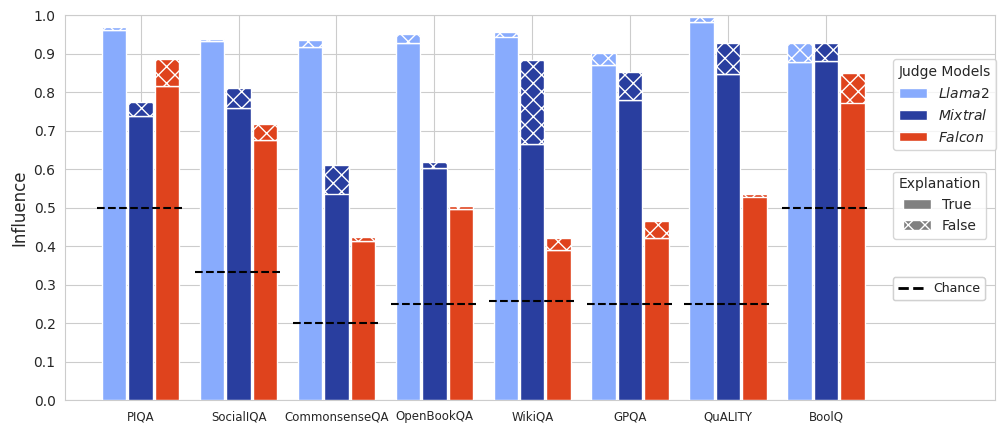

In [5]:
from src.plotting_utils import DATASET_NAMES

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

x_points = np.arange(len(datasets))
total_width = 0.75
spacing = 0.02
width = total_width / len(models)

for i, model in enumerate(models):
    y_points_True = np.array(
        [
            res["instuction_following_percentage"]
            for res in results
            if res["model"] == model and res["include_explanation"] == True
        ]
    )
    ax.bar(
        x_points + i * width + i * spacing,
        y_points_True,
        width=width,
        label=model,
        color=model_colors[i],
        zorder=5,
    )

    # plot on top of the bar
    y_points_False = np.array(
        [
            res["instuction_following_percentage"]
            for res in results
            if res["model"] == model and res["include_explanation"] == False
        ]
    )

    ax.bar(
        x_points + i * width + i * spacing,
        y_points_False - y_points_True,
        width=width,
        label=model,
        bottom=y_points_True,
        color=model_colors[i],
        hatch="XX",
        zorder=5,
    )

for i, dataset_name in enumerate(datasets):
    # plots random prediction like
    ax.plot(
        [i - width / 2 - 0.05, i + total_width - width / 2 + 0.08],
        [RANDOM_PERFORMANCE[dataset_name], RANDOM_PERFORMANCE[dataset_name]],
        color="black",
        linestyle="--",
        zorder=10,
    )

ax.set_xlim([-0.5, len(datasets) + 1])
ax.set_xticks(
    x_points + np.mean([i * (width + spacing) for i in range(len(models))]),
    [DATASET_NAMES[dataset_name] for dataset_name in datasets],
    rotation=0,
    fontsize=8.5,
)
ax.set_yticks(
    np.arange(0, 1.1, 0.1),
    ["{:.1f}".format(x) for x in np.arange(0, 1.1, 0.1)],
    fontsize=10,
)
ax.set_ylabel("Influence", fontsize=12)

legend_lines = [mpatches.Patch(facecolor=color, alpha=1) for color in model_colors]
legend_names = [MODEL_NAMES[model] for model in models]
legend = plt.legend(
    legend_lines,
    legend_names,
    loc=(0.89, 0.65),
    ncol=1,
    fontsize=10,
    title="Judge Models",
)
ax.add_artist(legend)

legend_lines = [
    mpatches.Patch(facecolor="grey", alpha=1, hatch=hatch) for hatch in [None, "XX"]
]
legend_names = ["True", "False"]
legend = plt.legend(
    legend_lines,
    legend_names,
    loc=(0.89, 0.42),
    ncol=1,
    fontsize=10,
    title="Explanation",
)
ax.add_artist(legend)

legend = plt.legend(
    [plt.Line2D([0], [0], color="black", ls="--", alpha=1, lw=2)],
    ["Chance"],
    loc=(0.89, 0.26),
    ncol=1,
    fontsize=9,
)
ax.add_artist(legend)
ax.set_ylim([0, 1])
plt.savefig("figures/instuction_following_percentage.pdf")
plt.show()

## Get performance

In [6]:
judge_level = "assistant"
additional_syste_prompt = "None"

results_advocate = []

for dataset_name in datasets:
    for model in models:
        # Load the data
        exp = get_last_exp_by_time(
            data_path, model, dataset_name, additional_syste_prompt
        )
        for advocate_level, include_explanation in zip(
            ["None", "assistant", "assistant"], [False, False, True]
        ):
            prob_filename = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            probabilities = load_pickle(os.path.join(exp, prob_filename))

            dataset_filename = (
                f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            )
            dataset = load_pickle(os.path.join(exp, dataset_filename))

            results_advocate.append(
                {
                    "dataset": dataset_name,
                    "dataset_raw": dataset,
                    "model": model,
                    "include_explanation": include_explanation,
                    "instuction_following_percentage": get_instuction_following_percentage(
                        dataset, probabilities
                    ).mean()
                    if advocate_level != "None"
                    else None,
                    "advocate_level": advocate_level,
                    "performance": get_metrics(advocate_level, probabilities, dataset),
                }
            )

/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


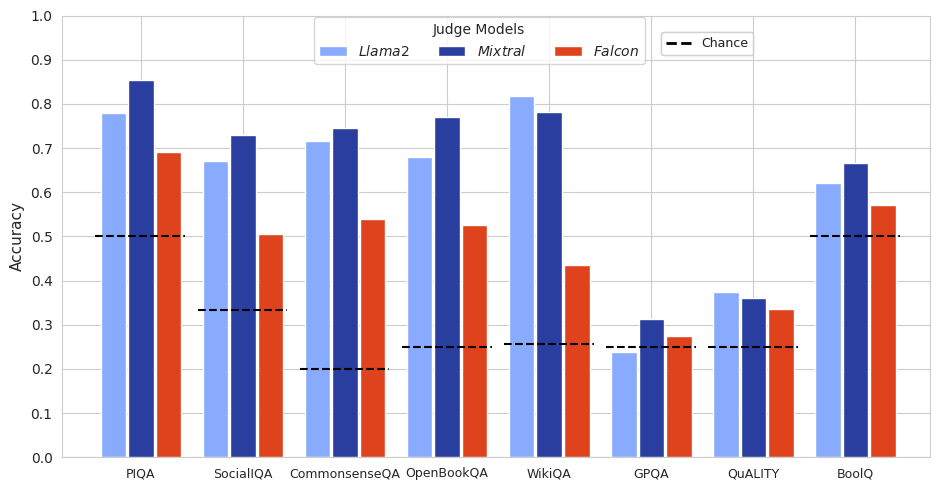

In [7]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(111)

advocate_level = "None"
include_explanation = False

x_points = np.arange(len(datasets))
total_width = 0.75
spacing = 0.02
width = total_width / len(models)

for i, model in enumerate(models):
    y_points = np.array(
        [
            np.array(
                [
                    res["performance"]["overall"]
                    for res in results_advocate
                    if res["model"] == model
                    and res["include_explanation"] == include_explanation
                    and res["advocate_level"] == advocate_level
                    and res["dataset"] == dataset_name
                ]
            )[0]
            for dataset_name in datasets
        ]
    )
    ax.bar(
        x_points + i * width + i * spacing,
        y_points,
        width=width,
        label=model,
        color=model_colors[i],
        zorder=5,
    )

for i, dataset_name in enumerate(datasets):
    # plots random prediction like
    ax.plot(
        [i - width / 2 - 0.05, i + total_width - width / 2 + 0.08],
        [RANDOM_PERFORMANCE[dataset_name], RANDOM_PERFORMANCE[dataset_name]],
        color="black",
        linestyle="--",
        zorder=10,
    )

ax.set_xlim([-0.5, len(datasets)])
ax.set_xticks(
    x_points + np.mean([i * (width + spacing) for i in range(len(models))]),
    [DATASET_NAMES[dataset_name] for dataset_name in datasets],
    rotation=0,
    fontsize=9,
)
ax.set_yticks(
    np.arange(0, 1.1, 0.1),
    ["{:.1f}".format(x) for x in np.arange(0, 1.1, 0.1)],
    fontsize=10,
)
ax.set_ylabel("Accuracy", fontsize=11)

legend_lines = [mpatches.Patch(facecolor=color, alpha=1) for color in model_colors]
legend_names = [MODEL_NAMES[model] for model in models]
legend = plt.legend(
    legend_lines,
    legend_names,
    loc=(0.29, 0.89),
    ncol=1 + len(models),
    fontsize=10,
    title="Judge Models",
)
ax.add_artist(legend)

legend = plt.legend(
    [plt.Line2D([0], [0], color="black", ls="--", alpha=1, lw=2)],
    ["Chance"],
    loc=(0.69, 0.91),
    ncol=1,
    fontsize=9,
)
ax.add_artist(legend)
ax.set_ylim([0, 1])
plt.tight_layout()
plt.savefig("figures/base_performance.pdf")
plt.show()

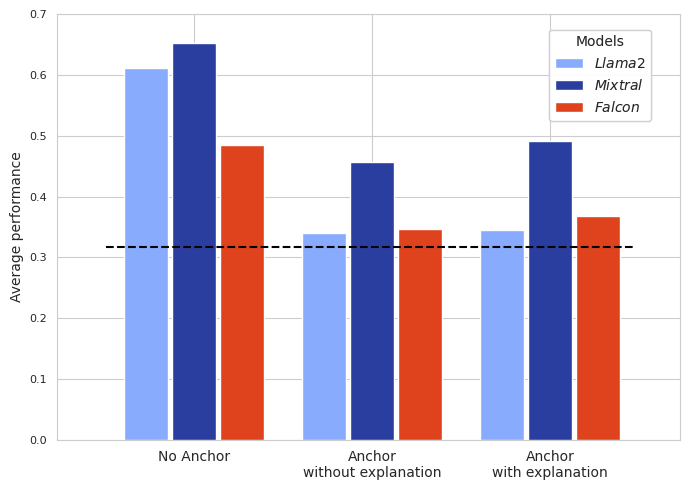

In [8]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

advocate_levels, include_explanations = ["None", "assistant", "assistant"], [
    False,
    False,
    True,
]

x_points = np.arange(len(advocate_levels))
total_width = 0.75
spacing = 0.02
width = total_width / len(advocate_levels)

for i, model in enumerate(models):
    y_points = np.array(
        [
            np.array(
                [
                    res["performance"]["overall"]
                    for res in results_advocate
                    if res["model"] == model
                    and res["include_explanation"] == include_explanation
                    and res["advocate_level"] == advocate_level
                ]
            ).mean()
            for advocate_level, include_explanation in zip(
                advocate_levels, include_explanations
            )
        ]
    )
    ax.bar(
        x_points + i * width + i * spacing,
        y_points,
        width=width,
        label=model,
        color=model_colors[i],
        zorder=5,
    )

mean_perf = np.mean([RANDOM_PERFORMANCE[dataset_name] for dataset_name in datasets])
ax.plot(
    [-width / 2 - 0.1, len(advocate_levels) - 1 + total_width],
    [mean_perf, mean_perf],
    color="black",
    linestyle="--",
    zorder=10,
)

legend_lines = [mpatches.Patch(facecolor=color, alpha=1) for color in model_colors]
legend_names = [MODEL_NAMES[model] for model in models]
legend = plt.legend(
    legend_lines, legend_names, loc=(0.79, 0.75), ncol=1, fontsize=10, title="Models"
)
ax.add_artist(legend)

ax.set_xlim([-0.5, len(advocate_levels)])
ax.set_xticks(
    x_points + np.mean([i * (width + spacing) for i in range(len(advocate_levels))]),
    ["No Anchor", "Anchor\nwithout explanation", "Anchor\nwith explanation"],
    rotation=0,
    fontsize=10,
)
ax.set_yticks(
    np.arange(0, 0.8, 0.1),
    ["{:.1f}".format(x) for x in np.arange(0, 0.8, 0.1)],
    fontsize=8,
)
ax.set_ylabel("Average performance")
plt.tight_layout()
plt.savefig("figures/average_performance.pdf")
plt.show()

In [9]:
advoate_level = "None"
include_explanation = False

ORIGINAL_PERFORNACE = {}
for model in models:
    for dataset in datasets:
        y_points = np.array(
            [
                np.array(
                    [
                        res["performance"]["overall"]
                        for res in results_advocate
                        if res["include_explanation"] == include_explanation
                        and res["advocate_level"] == advocate_level
                        and res["model"] == model
                        and res["dataset"] == dataset
                    ]
                )
            ]
        )
        ORIGINAL_PERFORNACE[(model, dataset)] = y_points.mean()

## Check instuction following based on if the explanation is correct

In [10]:
judge_level = "assistant"
advocate_level = "assistant"
additional_syste_prompt = "None"

results_fine = []

for model in models:
    for dataset_name in datasets:
        exp = get_last_exp_by_time(
            data_path, model, dataset_name, additional_syste_prompt
        )

        prob_filename = f"probabilities_{judge_level}_None_False.pkl"
        probabilities = load_pickle(os.path.join(exp, prob_filename))

        dataset_filename = f"dataset_{judge_level}_None_False.pkl"
        dataset = load_pickle(os.path.join(exp, dataset_filename))

        dataset = add_question_idx_in_dataset(dataset)
        question_indices_results_unbiased = get_sample_metrics(
            probabilities=probabilities, dataset=dataset
        )

        for include_explanation in [True, False]:
            prob_filename_bias = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            probabilities_bias = load_pickle(os.path.join(exp, prob_filename_bias))

            dataset_filename_bias = (
                f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            )
            dataset_bias = load_pickle(os.path.join(exp, dataset_filename_bias))

            dataset_bias = add_question_idx_in_dataset(dataset_bias)

            results_fine.append(
                {
                    "dataset": dataset_name,
                    "raw_dataset_bias": dataset_bias,
                    "probabilities_bias": probabilities_bias,
                    "model": model,
                    "include_explanation": include_explanation,
                    "question_indices_results_unbiased": question_indices_results_unbiased,
                    "instuction_following_percentage_wrong_explanation": get_instuction_following_percentage(
                        dataset=dataset_bias,
                        probabilities=probabilities_bias,
                        question_indices=[
                            x["question_idx"]
                            for x in question_indices_results_unbiased
                            if x["result"] == True
                        ],
                        explanation_is_correct=False,
                    ).mean(),
                    "instuction_following_percentage_correct_explanation": get_instuction_following_percentage(
                        dataset=dataset_bias,
                        probabilities=probabilities_bias,
                        question_indices=[
                            x["question_idx"]
                            for x in question_indices_results_unbiased
                            if x["result"] == False
                        ],
                        explanation_is_correct=True,
                    ).mean(),
                }
                | probability_stats(
                    dataset, probabilities, dataset_bias, probabilities_bias
                )
            )

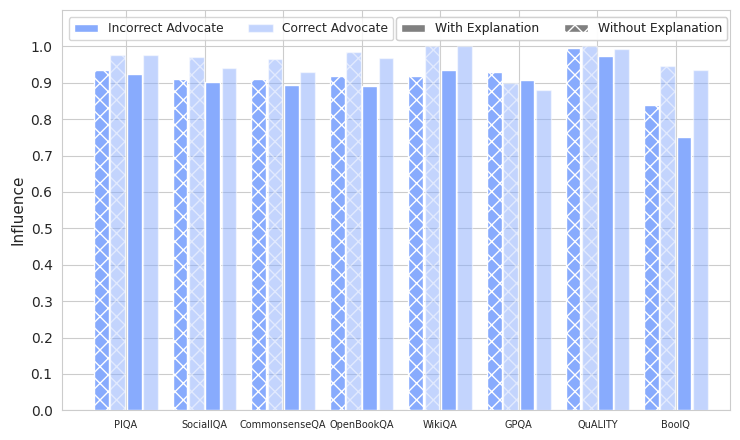

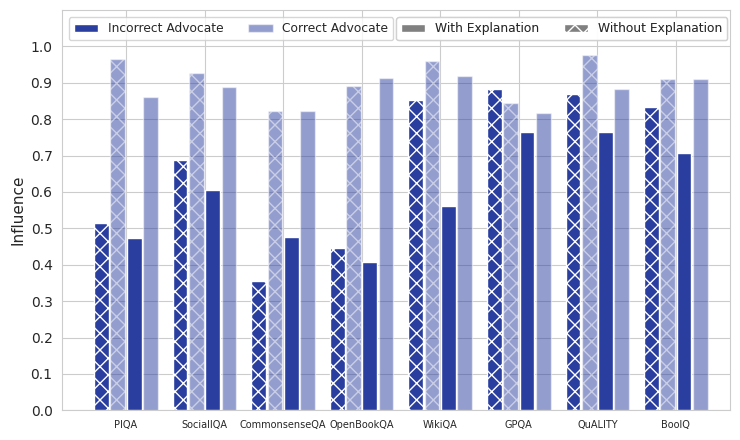

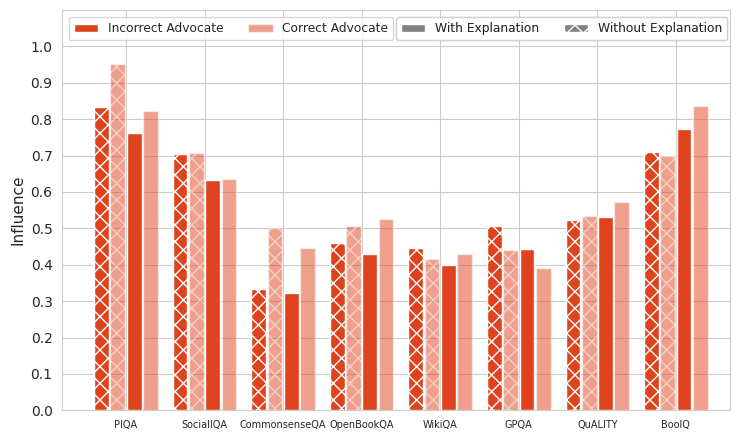

In [11]:
x_points = np.arange(len(datasets))
total_width = 0.75
spacing = 0.02
width = total_width / 4

for model_idx in range(len(models)):
    model = models[model_idx]

    fig = plt.figure(figsize=(7.5, 4.5))
    ax = fig.add_subplot(111)

    for include_explanation_idx, include_explanation in enumerate([False, True]):
        for mode_idx, mode in enumerate(["wrong", "correct"]):
            i = mode_idx + include_explanation_idx * 2

            y_points_True = np.array(
                [
                    res["instuction_following_percentage_" + mode + "_explanation"]
                    for res in results_fine
                    if res["model"] == model
                    and res["include_explanation"] == include_explanation
                ]
            )
            ax.bar(
                x_points + i * width + i * spacing,
                y_points_True,
                width=width,
                label=model,
                color=model_colors[model_idx],
                zorder=5,
                hatch="XX" if include_explanation == False else None,
                alpha=(0.5 if mode == "correct" else 1.0),
            )

    ax.set_xlim([-0.5, len(datasets)])
    ax.set_xticks(
        x_points + np.mean([i * (width + spacing) for i in range(4)]),
        [DATASET_NAMES[dataset_name] for dataset_name in datasets],
        rotation=0,
        fontsize=7,
    )
    ax.set_ylim([0, 1.1])
    ax.set_yticks(
        np.arange(0, 1.1, 0.1),
        ["{:.1f}".format(x) for x in np.arange(0, 1.1, 0.1)],
        fontsize=10,
    )
    ax.set_ylabel("Influence", fontsize=11)

    legend_lines = [
        mpatches.Patch(facecolor=model_colors[model_idx], alpha=1.0),
        mpatches.Patch(facecolor=model_colors[model_idx], alpha=0.5),
    ]
    legend_names = ["Incorrect Advocate", "Correct Advocate"]
    legend = plt.legend(
        legend_lines,
        legend_names,
        loc=(0.01, 0.925),
        ncol=2,
        fontsize=8.8,
    )
    ax.add_artist(legend)

    legend_lines = [
        mpatches.Patch(facecolor="grey", alpha=1.0, hatch=None),
        mpatches.Patch(facecolor="grey", alpha=1.0, hatch="XX"),
    ]
    legend_names = ["With Explanation", "Without Explanation"]
    legend = plt.legend(
        legend_lines,
        legend_names,
        loc=(0.5, 0.925),
        ncol=2,
        fontsize=8.8,
    )
    ax.add_artist(legend)

    plt.tight_layout()
    plt.savefig("figures/anchoring_per_answer_type_{}.pdf".format(model))
    plt.show()

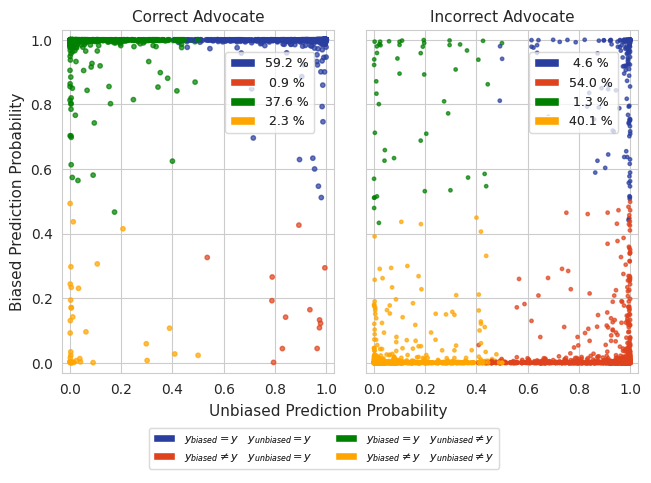

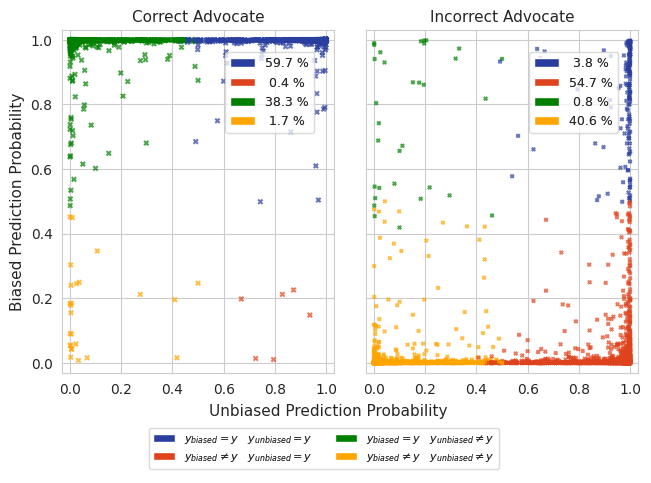

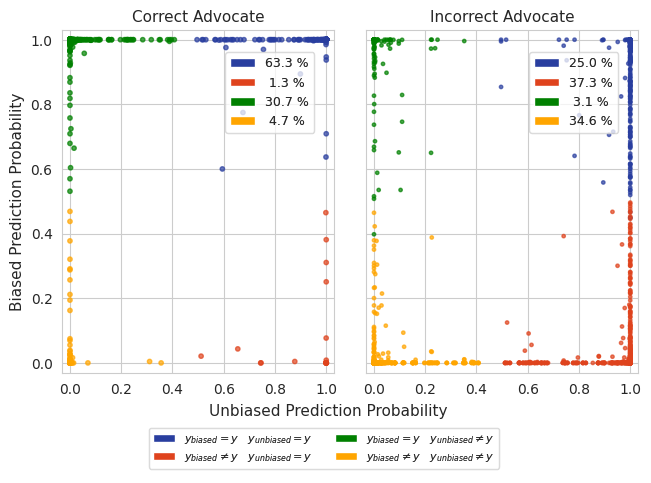

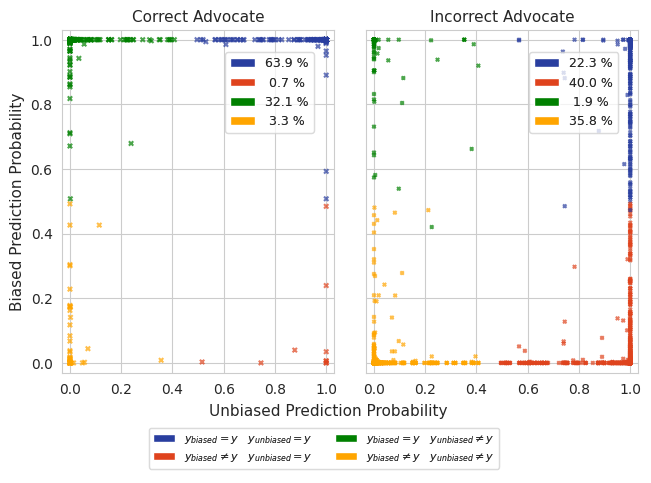

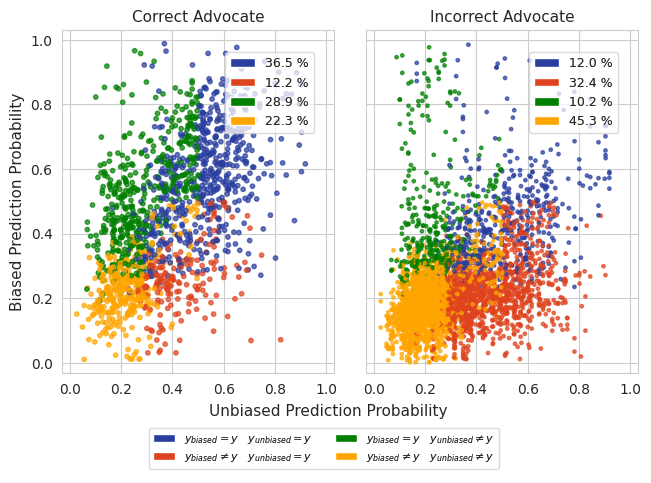

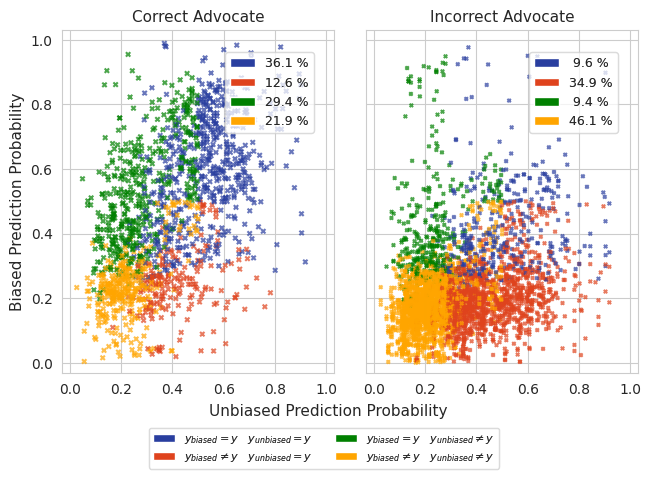

In [12]:
sizes = [10, 6]

myblue = "#293e9f"
myred = "#df431d"

for model in models:
    for include_explanation in [True, False]:
        fig, axes = plt.subplots(figsize=(8 / 1.2, 5 / 1.2), sharey=True, ncols=2)
        ax1, ax2 = axes

        def get_color(x, y):
            if x and y:
                return myblue
            if not x and y:
                return "green"
            if x and not y:
                return myred
            if not x and not y:
                return "orange"

        counting = [{myblue: 0, myred: 0, "green": 0, "orange": 0} for _ in range(2)]

        for dataset_name in datasets:
            res = [
                res
                for res in results_fine
                if res["model"] == model
                and res["include_explanation"] == include_explanation
                and res["dataset"] == dataset_name
            ][0]

            is_original_correct = res["is_original_correct"]
            is_bias_correct = res["is_bias_correct"]
            is_explanation_correct = res["is_explanation_correct"]
            prob_original_correct = res["prob_original_correct"]
            prob_bias_correct = res["prob_bias_correct"]

            colors = [
                get_color(x, y)
                for x, y in zip(
                    is_original_correct[is_explanation_correct],
                    is_bias_correct[is_explanation_correct],
                )
            ]
            color, count = np.unique(colors, return_counts=True)
            counting[0] = {
                k: (count[list(color).index(k)] if k in color else 0) + counting[0][k]
                for k, v in counting[0].items()
            }

            ax1.scatter(
                prob_original_correct[is_explanation_correct],
                prob_bias_correct[is_explanation_correct],
                color=colors,
                s=sizes[0],
                marker="x" if not include_explanation else "o",
                alpha=0.7,
            )

            colors = [
                get_color(x, y)
                for x, y in zip(
                    is_original_correct[~is_explanation_correct],
                    is_bias_correct[~is_explanation_correct],
                )
            ]
            color, count = np.unique(colors, return_counts=True)
            counting[1] = {
                k: (count[list(color).index(k)] if k in color else 0) + counting[1][k]
                for k, v in counting[1].items()
            }

            ax2.scatter(
                prob_original_correct[~is_explanation_correct],
                prob_bias_correct[~is_explanation_correct],
                color=colors,
                s=sizes[1],
                marker="x" if not include_explanation else "o",
                alpha=0.7,
            )

        for ax in [ax1, ax2]:
            ax.set_xlim([-0.03, 1.03])
            ax.set_ylim([-0.03, 1.03])

        ax1.set_ylabel("Biased Prediction Probability", fontsize=11)

        legend_lines = [
            mpatches.Patch(facecolor=color, alpha=1) for color in counting[0]
        ]
        legend_names = [
            ("{:.1f}".format(100 * v / np.sum(list(counting[0].values())))).rjust(
                4, " "
            )
            + " %"
            for k, v in counting[0].items()
        ]
        legend = ax1.legend(
            legend_lines,
            legend_names,
            loc=(0.6, 0.7),
            ncol=1,
            fontsize=9,
            framealpha=0.5,
        )
        ax1.add_artist(legend)

        legend_names = [
            ("{:.1f}".format(100 * v / np.sum(list(counting[1].values())))).rjust(
                4, " "
            )
            + " %"
            for v in counting[1].values()
        ]
        legend = ax2.legend(
            legend_lines,
            legend_names,
            loc=(0.6, 0.7),
            ncol=1,
            fontsize=9,
            framealpha=0.5,
        )
        ax2.add_artist(legend)

        ax1.set_title("Correct Advocate", fontsize=11)
        ax2.set_title("Incorrect Advocate", fontsize=11)

        biasing = [
            {k: v / np.sum(list(c.values())) for k, v in c.items()} for c in counting
        ]
        plt.tight_layout()
        # Add global xlabel
        fig.text(
            0.5,
            -0.0,
            "Unbiased Prediction Probability",
            ha="center",
            va="center",
            fontsize=11,
        )
        fig.text(
            0.5,
            -0.13,
            "  ",
            ha="center",
            va="center",
            fontsize=11,
        )

        def get_comment_type(color):
            if color == myblue:
                return r"$y_{biased} = y \quad y_{unbiased} = y$"
            elif color == myred:
                return r"$y_{biased} \neq y \quad y_{unbiased} = y$"
            elif color == "green":
                return r"$y_{biased} = y \quad y_{unbiased} \neq y$"
            elif color == "orange":
                return r"$y_{biased} \neq y \quad y_{unbiased} \neq y$"

        legend_names = [get_comment_type(k) for k in counting[0]]
        # global axes
        ax = fig.add_subplot(111)
        ax.set_axis_off()
        legend = ax.legend(
            legend_lines,
            legend_names,
            loc=(0.15, -0.28),
            ncol=2,
            fontsize=8,
            framealpha=0.5,
        )
        ax.add_artist(legend)

        # add space for the xlabel
        plt.savefig(
            f"figures/biasing_{model}_{include_explanation}.pdf", bbox_inches="tight"
        )

        plt.show()

## Compute calibration

In [13]:
judge_level = "assistant"
advocate_level = "assistant"
additional_system_prompt = "None"

results_calibration = []

for model in models:
    for dataset_name in datasets:
        exp = get_last_exp_by_time(
            data_path, model, dataset_name, additional_syste_prompt
        )

        prob_filename = f"probabilities_{judge_level}_None_False.pkl"
        probabilities = load_pickle(os.path.join(exp, prob_filename))

        dataset_filename = f"dataset_{judge_level}_None_False.pkl"
        dataset = load_pickle(os.path.join(exp, dataset_filename))

        dataset = add_question_idx_in_dataset(dataset)
        question_indices_results_unbiased = get_sample_metrics(
            probabilities=probabilities, dataset=dataset
        )

        for include_explanation in [True, False]:
            prob_filename_bias = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            probabilities_bias = load_pickle(os.path.join(exp, prob_filename_bias))

            dataset_filename_bias = (
                f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            )
            dataset_bias = load_pickle(os.path.join(exp, dataset_filename_bias))

            dataset_bias = add_question_idx_in_dataset(dataset_bias)

            results_calibration.append(
                {
                    "dataset": dataset_name,
                    "raw_dataset": dataset,
                    "probabilities": probabilities,
                    "raw_dataset_bias": dataset_bias,
                    "probabilities_bias": probabilities_bias,
                    "model": model,
                    "include_explanation": include_explanation,
                    "question_indices_results_unbiased": question_indices_results_unbiased,
                    "additional_system_prompt": additional_system_prompt,
                }
                | probability_stats(
                    dataset, probabilities, dataset_bias, probabilities_bias
                )
            )

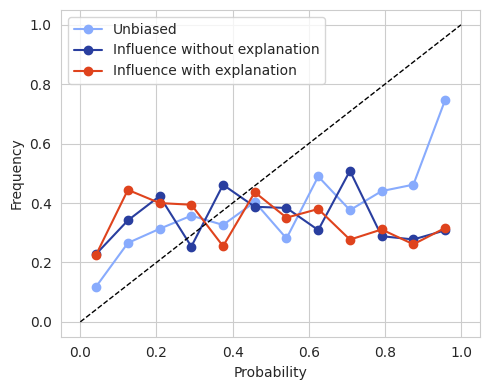

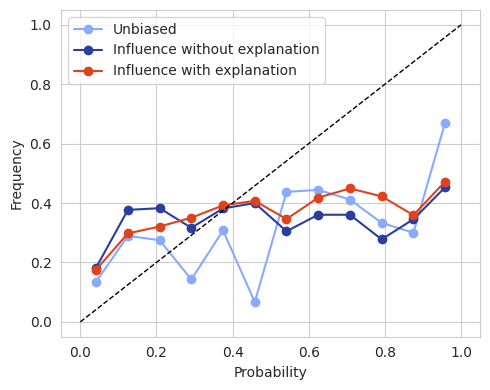

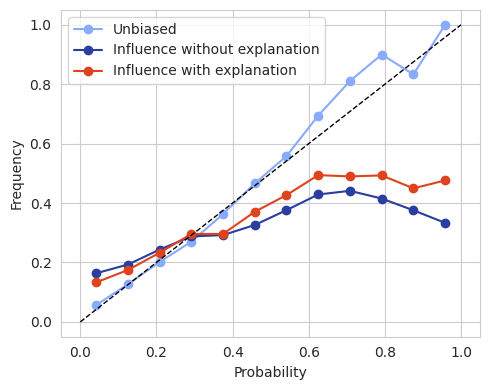

In [14]:
def get_probabilities(
    results_calibration, datasetss, model, include_explanation, biased=True, **kwargs
):
    all_probabilities = []

    for dataset_name in datasets:
        res = [
            res
            for res in results_calibration
            if res["model"] == model
            and res["include_explanation"] == include_explanation
            and res["dataset"] == dataset_name
            and all([res[k] == v for k, v in kwargs.items()])
        ]

        assert len(res) == 1
        res = res[0]

        probabilities = (
            res["probabilities"] if not biased else res["probabilities_bias"]
        )
        raw_dataset = res["raw_dataset"] if not biased else res["raw_dataset_bias"]

        probabilities = probabilities / np.sum(probabilities, axis=1)[:, np.newaxis]

        correct_probabilities = np.array(
            [
                x
                for i in range(len(raw_dataset))
                for x in probabilities[i][raw_dataset[i]["correct_answers_idx"]]
            ]
        )
        wrong_probabilities = np.array(
            [
                x
                for i in range(len(raw_dataset))
                for x in probabilities[i][raw_dataset[i]["wrong_answers_idx"]]
            ]
        )

        all_probabilities.append([[x, 1] for x in correct_probabilities])
        all_probabilities.append([[x, 0] for x in wrong_probabilities])

    all_probabilities = np.concatenate(all_probabilities)
    all_probabilities[np.isnan(all_probabilities[:, 0]), 0] = 0

    bin_indices = (all_probabilities[:, :1] >= bin_extremes[None, :]).sum(
        -1
    ) - 1  # all are bigger than 0

    return all_probabilities, bin_indices


# ax2 = fig.add_subplot(122)

n_bins = 12
# bin_extremes = np.concatenate([[0], np.logspace(-1.5, 0, n_bins)])
bin_extremes = np.linspace(0, 1, n_bins + 1)

data_x = np.array(
    [(bin_extremes[i - 1] + bin_extremes[i]) / 2 for i in range(1, n_bins + 1)]
)

colors = model_colors

for model in models:
    fig = plt.figure(figsize=(5, 4))
    ax1 = fig.add_subplot(111)
    for i, (mode, biased, name) in enumerate(
        zip(
            [
                {
                    "additional_system_prompt": "None",
                    "include_explanation": False,
                },
                {
                    "additional_system_prompt": "None",
                    "include_explanation": False,
                },
                {
                    "additional_system_prompt": "None",
                    "include_explanation": True,
                },
            ],
            [False, True, True],
            ["Unbiased", "Influence without explanation", "Influence with explanation"],
        )
    ):
        all_probabilities, bin_indices = get_probabilities(
            results_calibration, datasets, model, biased=biased, **mode
        )

        data_y = np.array(
            [np.mean(all_probabilities[bin_indices == i][:, 1]) for i in range(n_bins)]
        )

        mask = [i for i in range(n_bins) if not np.isnan(data_y[i])]

        ax1.plot(data_x[mask], data_y[mask], marker="o", label=name, color=colors[i])

        values, count = np.unique(bin_indices, return_counts=True)
        count = count / np.sum(count)

        # ax2.bar(data_x, [(count[values.tolist().index(i)]) if i in values else 0 for i in range(n_bins)], width=(bin_extremes[1] - bin_extremes[0]), alpha=0.4, zorder=i)

    ax1.plot([0, 1], [0, 1], "--", color="black", lw=1)
    ax1.set_xlabel("Probability")
    ax1.set_ylabel("Frequency")
    ax1.legend()
    plt.tight_layout()
    plt.savefig("figures/calibration_{}.pdf".format(model))
    plt.show()

## Prompting, CoT and few-shot

In [15]:
data_path_modes_few_shot = {
    None: "euler_logs/logs_21_03_v1",
    5: "euler_logs/logs_22_03_few_shot",
}

judge_level = "assistant"
advocate_level = "assistant"

modes = {
    "Default": {
        "additional_system_prompt": "None",
        "response_type": "None",
        "num_fewshot_samples": None,
    },
    "Critical\nprompt": {
        "additional_system_prompt": "Safe3",
        "response_type": "None",
        "num_fewshot_samples": None,
    },
    "Ignore via\nCoT prompting": {
        "additional_system_prompt": "None",
        "response_type": "Safe1",
        "num_fewshot_samples": None,
    },
    "Few-shot\nprompting": {
        "additional_system_prompt": "None",
        "response_type": "None",
        "num_fewshot_samples": 5,
    },
}

results_prompting = []
found = 0
not_found = 0

for model in models:
    for mode in modes.values():
        for dataset_name in datasets:
            try:
                exp = get_last_exp_by_time(
                    data_path_modes_few_shot[mode["num_fewshot_samples"]],
                    model,
                    dataset_name,
                    **mode,
                )

                prob_filename = f"probabilities_{judge_level}_None_False.pkl"
                probabilities = load_pickle(os.path.join(exp, prob_filename))

                dataset_filename = f"dataset_{judge_level}_None_False.pkl"
                dataset = load_pickle(os.path.join(exp, dataset_filename))

                dataset = add_question_idx_in_dataset(dataset)
                question_indices_results_unbiased = get_sample_metrics(
                    probabilities=probabilities, dataset=dataset
                )

                for include_explanation in [True, False]:
                    prob_filename_bias = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
                    probabilities_bias = load_pickle(
                        os.path.join(exp, prob_filename_bias)
                    )

                    dataset_filename_bias = f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
                    dataset_bias = load_pickle(os.path.join(exp, dataset_filename_bias))

                    dataset_bias = add_question_idx_in_dataset(dataset_bias)

                    results_prompting.append(
                        {
                            "dataset": dataset_name,
                            "raw_dataset_bias": dataset_bias,
                            "probabilities_bias": probabilities_bias,
                            "model": model,
                            "include_explanation": include_explanation,
                            "raw_dataset": dataset,
                            "probabilities": probabilities,
                            "judge_level": judge_level,
                            "advocate_level": advocate_level,
                        }
                        | mode
                    )
                found += 1
            except FileNotFoundError:
                print(mode | {"model": model, "dataset_name": dataset_name})
                not_found += 1

print(found, not_found)

96 0


include_explanation True


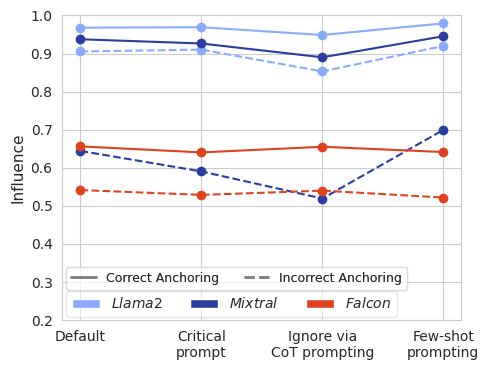

include_explanation False


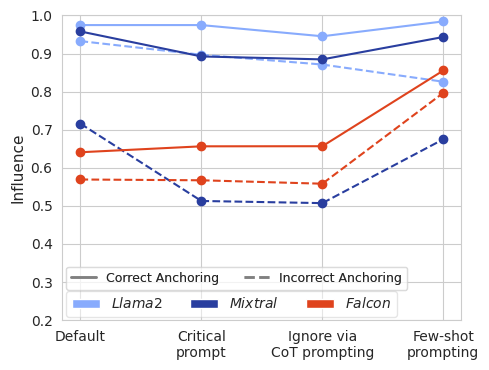

In [16]:
for i, include_explanation in enumerate([True, False]):
    fig = plt.figure(figsize=(5, 3.8))
    ax = fig.add_subplot(111)

    for model_idx, model in enumerate(models):
        results_one = []

        for mode in modes.values():
            results_datasets_one = []
            for dataset_name in datasets:
                res = [
                    res
                    for res in results_prompting
                    if res["model"] == model
                    and res["include_explanation"] == include_explanation
                    and res["dataset"] == dataset_name
                    and res["judge_level"] == judge_level
                    and res["advocate_level"] == advocate_level
                    and all([res[k] == v for k, v in mode.items()])
                ]

                assert len(res) == 1
                res = res[0]

                instuction_following_percentage_correct = (
                    get_instuction_following_percentage(
                        res["raw_dataset_bias"],
                        res["probabilities_bias"],
                        explanation_is_correct=True,
                    ).mean()
                )

                instuction_following_percentage_incorrect = (
                    get_instuction_following_percentage(
                        res["raw_dataset_bias"],
                        res["probabilities_bias"],
                        explanation_is_correct=False,
                    ).mean()
                )

                instuction_following_percentage_all = (
                    get_instuction_following_percentage(
                        res["raw_dataset_bias"],
                        res["probabilities_bias"],
                    ).mean()
                )

                results_datasets_one.append(
                    [
                        instuction_following_percentage_correct,
                        instuction_following_percentage_incorrect,
                        instuction_following_percentage_all,
                    ]
                )

            results_one.append(
                [
                    np.mean([x[0] for x in results_datasets_one]),
                    np.mean([x[1] for x in results_datasets_one]),
                    np.mean([x[2] for x in results_datasets_one]),
                ]
            )

        ax.plot(
            np.arange(len(modes)),
            [x[0] for x in results_one],
            marker="o",
            color=model_colors[model_idx],
        )

        ax.plot(
            np.arange(len(modes)),
            [x[1] for x in results_one],
            "--",
            marker="o",
            color=model_colors[model_idx],
        )

    ax.set_ylim([0.2, 1.0])
    ax.set_ylabel("Influence", fontsize=11)

    ax.set_xticks(np.arange(len(modes)), list(modes.keys()), rotation=0)

    legend_lines = [
        mpatches.Patch(facecolor=model_colors[model_idx], alpha=1)
        for model_idx in range(len(models))
    ]
    legend = ax.legend(
        legend_lines,
        [MODEL_NAMES[model] for model in models],
        loc=(0.01, 0.01),
        ncol=3,
        fontsize=10,
        framealpha=0.5,
    )
    ax.add_artist(legend)

    legend_lines = [
        plt.Line2D([0], [0], color="grey", alpha=1, ls=ls, lw=2) for ls in ["-", "--"]
    ]
    legend = ax.legend(
        legend_lines,
        ["Correct Anchoring", "Incorrect Anchoring"],
        loc=(0.01, 0.1),
        ncol=2,
        fontsize=9,
        framealpha=0.5,
    )
    ax.add_artist(legend)

    print("include_explanation", include_explanation)
    plt.tight_layout()
    plt.savefig("figures/prompting_{}.pdf".format(include_explanation))
    plt.show()

In [18]:
# Add more options for the appendix with a table

model_judges = ["Llama-2-70b-chat", "Mixtral", "falcon-40b"]
additional_system_prompts = ["None", "Safe1", "Safe3", "Safe5"]
response_types = ["None", "Safe1"]

print("\\begin{tabular}{| c | c | c | c | c | c |}")
print("\\toprule")
print(
    "System Prompt & Response Prompt & Few-shot examples & \\llama & \\mixtral & \\falcon \\\\"
)
print("\\midrule")

cnt = 0
for additional_system_prompt in additional_system_prompts:
    # break
    for response_type in response_types:
        # break
        for new_few_shot in [None, 5]:
            # break

            system_name = {
                "None": "None",
                "Safe1": "Suspicious",
                "Safe3": "Critical",
                "Safe5": "Rejecting",
            }[additional_system_prompt]
            response_name = "None" if response_type == "None" else "CoT"
            few_shot_name = "None" if new_few_shot is None else "5"

            print(f"{system_name}&{response_name}&{few_shot_name}&", end="")
            for model in models:
                exp = get_last_exp_by_time(
                    data_path_modes_few_shot[new_few_shot],
                    model,
                    dataset_name,
                    additional_system_prompt=additional_system_prompt,
                    response_type=response_type,
                    num_fewshot_samples=new_few_shot,
                )

                prob_filename = f"probabilities_{judge_level}_None_False.pkl"
                probabilities = load_pickle(os.path.join(exp, prob_filename))

                dataset_filename = f"dataset_{judge_level}_None_False.pkl"
                dataset = load_pickle(os.path.join(exp, dataset_filename))

                dataset = add_question_idx_in_dataset(dataset)
                question_indices_results_unbiased = get_sample_metrics(
                    probabilities=probabilities, dataset=dataset
                )

                temp = []
                for include_explanation in [True, False]:
                    prob_filename_bias = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
                    probabilities_bias = load_pickle(
                        os.path.join(exp, prob_filename_bias)
                    )

                    dataset_filename_bias = f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
                    dataset_bias = load_pickle(os.path.join(exp, dataset_filename_bias))

                    dataset_bias = add_question_idx_in_dataset(dataset_bias)

                    temp.append(
                        (
                            get_instuction_following_percentage(
                                dataset_bias,
                                probabilities_bias,
                            ).mean()
                        )
                    )

                # print("---->" + " & " if model != models[-1] else " \\\\ \n")

                print(
                    f"{temp[0]:.3f}, {temp[1]:.3f}",
                    end=" & " if model != models[-1] else " \\\\ \n",
                )
    cnt += 1
    if cnt < len(additional_system_prompts):
        print("\\midrule")

print("\\bottomrule")
print("\\end{tabular}")
print(
    "\\caption{Prompting effect on anchoring. The table shows the anchoring bias for different models and different prompting strategies. First number is the anchoring bias when explanation is provided, the second number is the anchoring bias without explanation.}"
)
print("\\label{tab:prompting_anchoring_all}")

\begin{tabular}{| c | c | c | c | c | c |}
\toprule
System Prompt & Response Prompt & Few-shot examples & \llama & \mixtral & \falcon \\
\midrule
None&None&None&0.865, 0.938 & 0.885, 0.922 & 0.845, 0.797 \\ 
None&None&5&0.959, 0.962 & 0.856, 0.815 & 0.726, 0.800 \\ 
None&CoT&None&0.775, 0.767 & 0.828, 0.853 & 0.767, 0.765 \\ 
None&CoT&5&0.951, 0.956 & 0.815, 0.869 & 0.782, 0.613 \\ 
\midrule
Suspicious&None&None&0.912, 0.958 & 0.853, 0.882 & 0.823, 0.782 \\ 
Suspicious&None&5&0.959, 0.959 & 0.851, 0.808 & 0.731, 0.849 \\ 
Suspicious&CoT&None&0.760, 0.623 & 0.725, 0.780 & 0.818, 0.782 \\ 
Suspicious&CoT&5&0.949, 0.936 & 0.797, 0.862 & 0.762, 0.674 \\ 
\midrule
Critical&None&None&0.892, 0.958 & 0.860, 0.725 & 0.820, 0.828 \\ 
Critical&None&5&0.959, 0.954 & 0.856, 0.764 & 0.728, 0.792 \\ 
Critical&CoT&None&0.795, 0.848 & 0.735, 0.682 & 0.785, 0.818 \\ 
Critical&CoT&5&0.946, 0.946 & 0.803, 0.856 & 0.754, 0.618 \\ 
\midrule
Rejecting&None&None&0.897, 0.835 & 0.870, 0.787 & 0.863, 0.772 \\ 


## Personas

In [84]:
data_path_personas = [
    "euler_logs/logs_20_03_v1",
    "euler_logs/logs_20_03_v1",
    "euler_logs/logs_22_03_falcon_levels",
]

additional_system_prompt = "Safe3"
response_type = "None"
num_fewshot_samples = None
models_to_check = models


results_personas = []

for judge_level in LEVELS:
    for advocate_level in LEVELS:
        for model_idx, model in enumerate(models_to_check):
            for dataset_name in datasets:
                exp = get_last_exp_by_time(
                    data_path_personas[model_idx],
                    model,
                    dataset_name,
                    additional_system_prompt=additional_system_prompt,
                    response_type=response_type,
                    num_fewshot_samples=num_fewshot_samples,
                )

                prob_filename = f"probabilities_{judge_level}_None_False.pkl"
                probabilities = load_pickle(os.path.join(exp, prob_filename))

                dataset_filename = f"dataset_{judge_level}_None_False.pkl"
                dataset = load_pickle(os.path.join(exp, dataset_filename))

                dataset = add_question_idx_in_dataset(dataset)
                question_indices_results_unbiased = get_sample_metrics(
                    probabilities=probabilities, dataset=dataset
                )

                for include_explanation in [True, False]:
                    prob_filename_bias = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
                    probabilities_bias = load_pickle(
                        os.path.join(exp, prob_filename_bias)
                    )

                    dataset_filename_bias = f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
                    dataset_bias = load_pickle(os.path.join(exp, dataset_filename_bias))

                    dataset_bias = add_question_idx_in_dataset(dataset_bias)

                    results_personas.append(
                        {
                            "dataset": dataset_name,
                            "raw_dataset_bias": dataset_bias,
                            "probabilities_bias": probabilities_bias,
                            "model": model,
                            "include_explanation": include_explanation,
                            "raw_dataset": dataset,
                            "probabilities": probabilities,
                            "additional_system_prompt": additional_system_prompt,
                            "judge_level": judge_level,
                            "advocate_level": advocate_level,
                        }
                    )

In [85]:
include_explanations = [False, True]

desired_levels = ["level_1", "level_2", "level_3", "level_4", "level_5"]
additional_system_prompt = "Safe3"

all_results = {}

for model in models_to_check:
    for include_explanation in include_explanations:
        for judge_level_idx, judge_level in enumerate(desired_levels):
            results_one = []

            for advocate_level in desired_levels:
                results_datasets_one = []
                for dataset_name in datasets:
                    res = [
                        res
                        for res in results_personas
                        if res["model"] == model
                        and res["include_explanation"] == include_explanation
                        and res["dataset"] == dataset_name
                        and res["additional_system_prompt"] == additional_system_prompt
                        and res["judge_level"] == judge_level
                        and res["advocate_level"] == advocate_level
                    ][0]

                    instuction_following_percentage_correct = (
                        get_instuction_following_percentage(
                            res["raw_dataset_bias"],
                            res["probabilities_bias"],
                            explanation_is_correct=True,
                        ).mean()
                    )

                    instuction_following_percentage_incorrect = (
                        get_instuction_following_percentage(
                            res["raw_dataset_bias"],
                            res["probabilities_bias"],
                            explanation_is_correct=False,
                        ).mean()
                    )

                    instuction_following_percentage_overall = (
                        get_instuction_following_percentage(
                            res["raw_dataset_bias"],
                            res["probabilities_bias"],
                        ).mean()
                    )

                    performance = get_metrics(
                        advocate_level,
                        res["probabilities_bias"],
                        res["raw_dataset_bias"],
                    )

                    results_datasets_one.append(
                        [
                            instuction_following_percentage_correct,
                            instuction_following_percentage_incorrect,
                            instuction_following_percentage_overall,
                            performance,
                        ]
                    )

                results_one.append(
                    [
                        np.mean([x[0] for x in results_datasets_one]),
                        np.mean([x[1] for x in results_datasets_one]),
                        np.mean([x[2] for x in results_datasets_one]),
                        np.mean([x[3]["overall"] for x in results_datasets_one]),
                    ]
                )

            all_results[(model, include_explanation, judge_level)] = results_one

/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


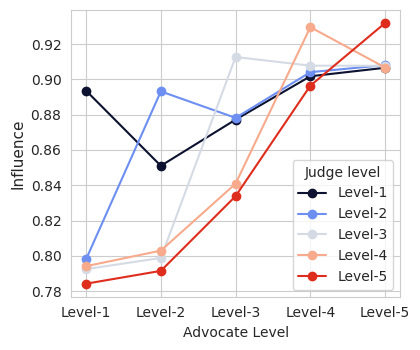

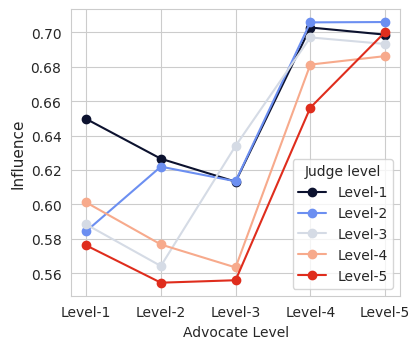

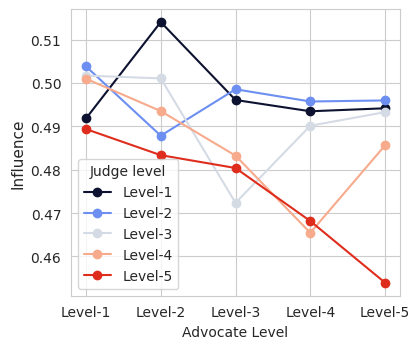

In [86]:
for model in models_to_check:
    fig = plt.figure(figsize=(4.3, 3.6))
    ax = fig.add_subplot(111)

    colors = [GREG_PALLETTE[i] for i in [0, 4, 6, 8, 12]]

    models_to_plot = models_to_check
    include_explanations = [True, False]
    levels_list = [x[0].upper() + x[1:].replace("_", "-") for x in desired_levels]

    for judge_level_idx, judge_level in enumerate(desired_levels):
        ax.plot(
            np.arange(len(desired_levels)),
            np.array(
                [
                    np.array(v)[:, 2]
                    for k, v in all_results.items()
                    if k[0] == model
                    and k[1] in include_explanations
                    and k[2] == judge_level
                ]
            ).mean(0),
            marker="o",
            color=colors[judge_level_idx],
            label=levels_list[judge_level_idx],
        )

    ax.legend(title="Judge level")
    ax.set_xticks(np.arange(len(desired_levels)), levels_list, rotation=0)
    ax.set_xlabel("Advocate Level")
    ax.set_ylabel("Influence", fontsize=11)
    plt.tight_layout()
    plt.savefig(f"figures/personas_{model}.pdf")
    plt.show()

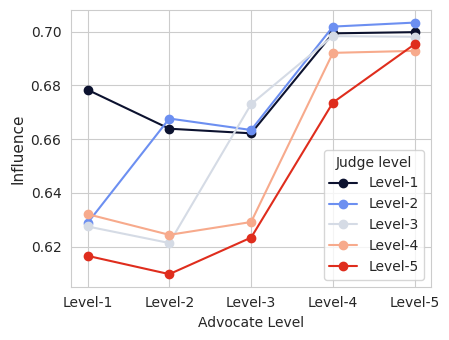

In [87]:
fig = plt.figure(figsize=(4.6, 3.5))
ax = fig.add_subplot(111)

colors = [GREG_PALLETTE[i] for i in [0, 4, 6, 8, 12]]

models_to_plot = models_to_check
include_explanations = [True, False]
levels_list = [x[0].upper() + x[1:].replace("_", "-") for x in desired_levels]

for judge_level_idx, judge_level in enumerate(desired_levels):
    ax.plot(
        np.arange(len(desired_levels)),
        np.array(
            [
                np.array(v)[:, 2]
                for k, v in all_results.items()
                if k[0] in models_to_plot
                and k[1] in include_explanations
                and k[2] == judge_level
            ]
        ).mean(0),
        marker="o",
        color=colors[judge_level_idx],
        label=levels_list[judge_level_idx],
    )

ax.legend(title="Judge level")
ax.set_xticks(np.arange(len(desired_levels)), levels_list, rotation=0)
ax.set_xlabel("Advocate Level")
ax.set_ylabel("Influence", fontsize=11)
plt.tight_layout()
plt.savefig("figures/personas.pdf")
plt.show()

## Num Explanations

In [32]:
data_path_num_explanations_slurm_logs = (
    "euler_logs/logs_22_03_num_explanations/slurm_logs"
)

all_num_explanations = [1, 2, 3, 4, 5]

results_num_explanations = {}

for num_explanations in all_num_explanations:
    for model_idx, model in enumerate(models):
        for dataset_name in datasets:
            for include_explanation in [True, False]:
                path = os.path.join(
                    data_path_num_explanations_slurm_logs,
                    f"scalable_oversight_num_explanations_{dataset_name}_predictions_{model}_{num_explanations}",
                )

                with open(path, "r") as f:
                    lines = f.readlines()
                    line = [
                        x
                        for x in lines
                        if f"System prompt assistant advocate level assistant include_explanation {include_explanation} metric"
                        in x
                    ]

                    assert len(line) == 1
                    line = line[0]

                    perf = float(line.split("overall': ")[1].split(",")[0])

                results_num_explanations[
                    (num_explanations, model, dataset_name, include_explanation)
                ] = perf

0.6118456302151954


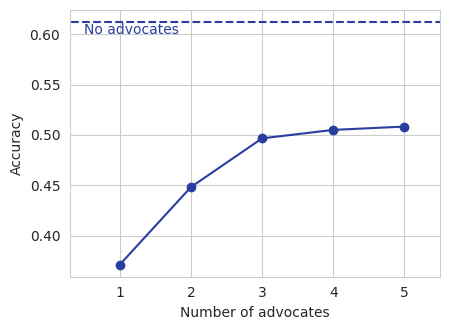

0.6525925010979359


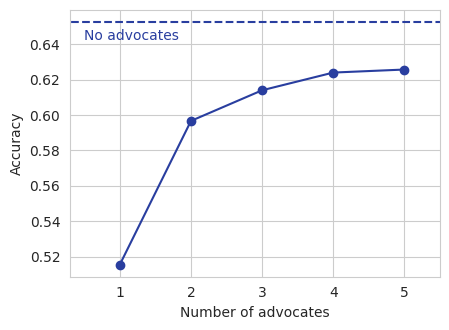

0.48423678547781945


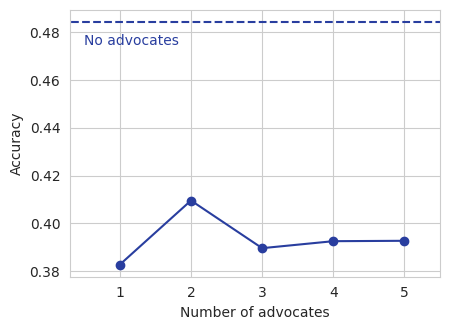

In [83]:
include_explanation = True

# for dataset_name in datasets:
#     for model in models:
# AVG_PERFORMANCE = 0.582891638930317

models_to_plot = [
    "Llama-2-70b-chat",
    "Mixtral",
    "falcon-40b",
]

for model_to_plot in models_to_plot:
    models_now = [model_to_plot]

    fig = plt.figure(figsize=(4.6, 3.4))
    ax = fig.add_subplot(111)

    datasets_to_plot = [
        "piqa",
        "siqa",
        "commonsense_qa",
        "openbookqa",
        "wiki_qa",
        "gpqa",
        "quality",
        "boolq",
    ]

    data = []
    for num_explanations in all_num_explanations:
        data_one = [
            results_num_explanations[
                (num_explanations, model, dataset_name, include_explanation)
            ]
            for model in models_now
            for dataset_name in datasets_to_plot
        ]
        data.append(np.mean(data_one))

    ax.plot(all_num_explanations, data, marker="o", color=GREG_PALLETTE[2])
    orig = np.mean(
        [
            ORIGINAL_PERFORNACE[(model, dataset)]
            for model in models_now
            for dataset in datasets_to_plot
        ]
    )
    print(orig)
    ax.plot([0, 6], [orig, orig], "--", color=GREG_PALLETTE[2])
    ax.text(
        0.5,
        orig - 0.008,
        "No advocates",
        fontsize=10,
        verticalalignment="center",
        color=GREG_PALLETTE[2],
    )

    ax.set_xlabel("Number of advocates")
    # ax.set_ylim([0.39, 0.53])
    ax.set_xlim([0.3, 5.5])
    ax.set_ylabel("Accuracy")
    plt.tight_layout()
    plt.savefig(f"figures/num_explanations_{model_to_plot}.pdf")
    plt.show()

## Quality and Quantity of information

In [ ]:
# We cannot really test this, since the models are overly biased ...

## Presentation of information

In [59]:
from src.definitions import CONFIDENCES_LIST

# correct explanation but with varying degree of confidence

data_path_confidence = "euler_logs/logs_24_03_confidence"

additional_system_prompt = "None"
response_type = "None"
num_fewshot_samples = None
judge_level = "assistant"
advocate_level = "assistant"

results_confidence = []

for model_idx, model in enumerate(models):
    for dataset_name in datasets:
        exp = get_last_exp_by_time(
            data_path_confidence,
            model,
            dataset_name,
        )

        for include_explanation in [True, False]:
            for confidence in CONFIDENCES_LIST:
                prob_filename_bias = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}_{confidence}.pkl"
                probabilities_bias = load_pickle(os.path.join(exp, prob_filename_bias))

                dataset_filename_bias = f"dataset_{judge_level}_{advocate_level}_{include_explanation}_{confidence}.pkl"
                dataset_bias = load_pickle(os.path.join(exp, dataset_filename_bias))

                dataset_bias = add_question_idx_in_dataset(dataset_bias)

                results_confidence.append(
                    {
                        "dataset": dataset_name,
                        "raw_dataset_bias": dataset_bias,
                        "probabilities_bias": probabilities_bias,
                        "model": model,
                        "include_explanation": include_explanation,
                        "confidence": confidence,
                    }
                )

/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


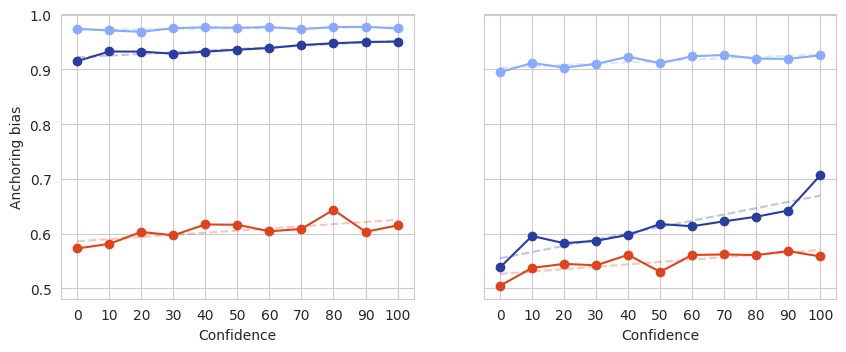

In [60]:
include_explanation = False

results = {}
for model in models:
    values = []

    for confidence in CONFIDENCES_LIST:
        vals = {
            "performance": [],
            "performance_correct": [],
            "performance_incorrect": [],
            "anchoring_bias": [],
            "anchoring_bias_correct": [],
            "anchoring_bias_incorrect": [],
        }

        for dataset_name in datasets:
            res = [
                res
                for res in results_confidence
                if res["model"] == model
                and res["confidence"] == confidence
                and res["include_explanation"] == include_explanation
                and res["dataset"] == dataset_name
            ]
            assert len(res) == 1
            res = res[0]

            vals["performance"].append(
                get_metrics(
                    "assistant", res["probabilities_bias"], res["raw_dataset_bias"]
                )["overall"]
            )

            indices_correct = [
                i
                for i in range(len(res["raw_dataset_bias"]))
                if res["raw_dataset_bias"][i]["explanation_is_correct"] == True
            ]
            indices_incorrect = [
                i
                for i in range(len(res["raw_dataset_bias"]))
                if res["raw_dataset_bias"][i]["explanation_is_correct"] == False
            ]

            vals["performance_correct"].append(
                get_metrics(
                    "assistant",
                    res["probabilities_bias"],
                    res["raw_dataset_bias"],
                    indices=indices_correct,
                )["overall"]
            )
            vals["performance_incorrect"].append(
                get_metrics(
                    "assistant",
                    res["probabilities_bias"],
                    res["raw_dataset_bias"],
                    indices=indices_incorrect,
                )["overall"]
            )

            vals["anchoring_bias"].append(
                get_instuction_following_percentage(
                    res["raw_dataset_bias"], res["probabilities_bias"]
                ).mean()
            )
            vals["anchoring_bias_correct"].append(
                get_instuction_following_percentage(
                    res["raw_dataset_bias"],
                    res["probabilities_bias"],
                    indices=indices_correct,
                ).mean()
            )
            vals["anchoring_bias_incorrect"].append(
                get_instuction_following_percentage(
                    res["raw_dataset_bias"],
                    res["probabilities_bias"],
                    indices=indices_incorrect,
                ).mean()
            )

        values.append({k: np.mean(v) for k, v in vals.items()})

    results[model] = values

# for k in values[0].keys():
#     fig = plt.figure(figsize=(5, 3.7))
#     ax = fig.add_subplot(111)

#     vals = [x[k] for x in values]
#     ax.plot(np.arange(len(values)), vals, marker="o", color=GREG_PALLETTE[2])

#     from sklearn.linear_model import LinearRegression

#     model = LinearRegression()
#     model.fit(np.array(CONFIDENCES_LIST).reshape(-1, 1), vals)

#     preds = model.predict(np.array(CONFIDENCES_LIST).reshape(-1, 1))
#     ax.plot(np.arange(len(values)), preds, "--", color=GREG_PALLETTE[2], alpha=0.3)

#     ax.set_xticks(
#         np.arange(len(CONFIDENCES_LIST)), [f"{x}" for x in CONFIDENCES_LIST], rotation=0
#     )
#     ax.set_xlabel("Confidence")
#     # ax.set_xlim([0.3, 5.5])
#     ax.set_ylabel("Accuracy")
#     # plt.savefig("figures/confidence.pdf")
#     print(k)
#     plt.show()


fig, axes = plt.subplots(figsize=(10, 3.7), ncols=2, sharey=True)
# ax.set_ylim([0.89, 0.96])
# ax_twinx.set_ylim([0.52, 0.72])

colors = [GREG_PALLETTE[i] for i in [2, 10]]

for model_idx, model in enumerate(models):
    values = results[model]

    for i, k in enumerate(["anchoring_bias_correct", "anchoring_bias_incorrect"]):
        vals = [x[k] for x in values]

        axes[i].plot(
            np.arange(len(values)), vals, marker="o", color=model_colors[model_idx]
        )

        from sklearn.linear_model import LinearRegression

        model = LinearRegression()
        model.fit(np.array(CONFIDENCES_LIST).reshape(-1, 1), vals)

        preds = model.predict(np.array(CONFIDENCES_LIST).reshape(-1, 1))
        axes[i].plot(
            np.arange(len(values)),
            preds,
            "--",
            color=model_colors[model_idx],
            alpha=0.3,
        )

        axes[i].set_xticks(
            np.arange(len(CONFIDENCES_LIST)),
            [f"{x}" for x in CONFIDENCES_LIST],
            rotation=0,
        )

        axes[i].set_xlabel("Confidence")
        # ax.set_xlim([0.3, 5.5])

axes[0].set_ylabel("Anchoring bias")

# plt.savefig("figures/confidence.pdf")
plt.show()

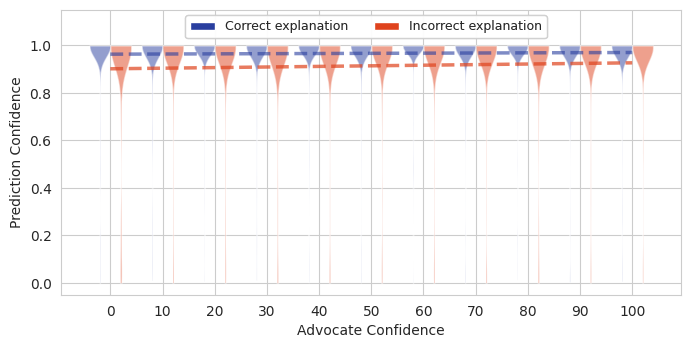

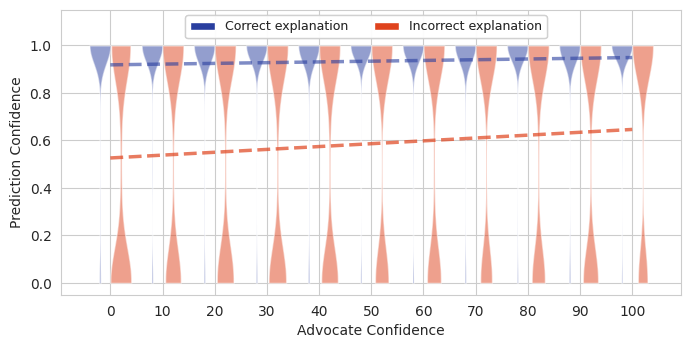

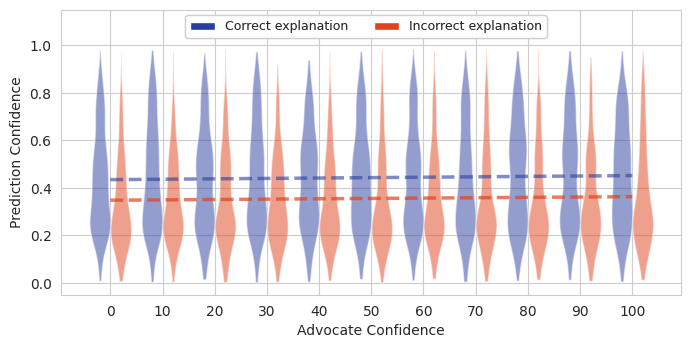

In [81]:
# How about raw confidence and the confidence provided to the model?

include_explanation = False


for model in models:
    values = []
    for confidence in CONFIDENCES_LIST:
        vals = {
            "confidence": [],
            "confidence_correct": [],
            "confidence_incorrect": [],
        }
        for dataset_name in datasets:
            res = [
                res
                for res in results_confidence
                if res["model"] == model
                and res["confidence"] == confidence
                and res["include_explanation"] == include_explanation
                and res["dataset"] == dataset_name
            ]
            assert len(res) == 1
            res = res[0]

            for i in range(len(res["raw_dataset_bias"])):
                explanation_is_correct = res["raw_dataset_bias"][i][
                    "explanation_is_correct"
                ]

                confidence_raw = res["probabilities_bias"][i][
                    res["raw_dataset_bias"][i]["explanation_advocate_idx"]
                ] / np.sum(res["probabilities_bias"][i])

                if np.isnan(confidence_raw):
                    continue

                vals["confidence"].append(confidence_raw)
                if explanation_is_correct:
                    vals["confidence_correct"].append(confidence_raw)
                else:
                    vals["confidence_incorrect"].append(confidence_raw)

        values.append(vals)

    fig = plt.figure(figsize=(8, 3.7))
    ax = fig.add_subplot(111)

    width = 0.4

    parts = ax.violinplot(
        [
            np.random.choice(values[i]["confidence_correct"], size=500, replace=False)
            for i in range(len(CONFIDENCES_LIST))
        ],
        np.arange(len(CONFIDENCES_LIST)) - width / 2,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=width,
        # points=100000,
    )

    for pc in parts["bodies"]:
        pc.set_facecolor(GREG_PALLETTE[2])
        # pc.set_edgecolor('black')
        pc.set_alpha(0.5)

    means = np.array(
        [
            np.mean(x)
            for x in [
                values[i]["confidence_correct"] for i in range(len(CONFIDENCES_LIST))
            ]
        ]
    )
    from sklearn.linear_model import LinearRegression

    model_lin = LinearRegression()
    model_lin.fit(np.array(CONFIDENCES_LIST).reshape(-1, 1), means)

    preds = model_lin.predict(np.array(CONFIDENCES_LIST).reshape(-1, 1))
    ax.plot(
        np.arange(len(values)),
        preds,
        "--",
        color=GREG_PALLETTE[2],
        alpha=0.6,
        zorder=20,
        lw=2.5,
    )

    parts = ax.violinplot(
        [
            np.random.choice(values[i]["confidence_incorrect"], size=500, replace=False)
            for i in range(len(CONFIDENCES_LIST))
        ],
        np.arange(len(CONFIDENCES_LIST)) + width / 2,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=width,
    )

    for pc in parts["bodies"]:
        pc.set_facecolor(GREG_PALLETTE[10])
        # pc.set_edgecolor('black')
        pc.set_alpha(0.5)

    means = np.array(
        [
            np.mean(x)
            for x in [
                values[i]["confidence_incorrect"] for i in range(len(CONFIDENCES_LIST))
            ]
        ]
    )
    from sklearn.linear_model import LinearRegression
    from src.definitions import CONFIDENCES_LIST

    model_lin = LinearRegression()
    model_lin.fit(np.array(CONFIDENCES_LIST).reshape(-1, 1), means)

    preds = model_lin.predict(np.array(CONFIDENCES_LIST).reshape(-1, 1))
    ax.plot(
        np.arange(len(values)),
        preds,
        "--",
        color=GREG_PALLETTE[10],
        alpha=0.7,
        zorder=20,
        lw=2.5,
    )

    ax.set_xticks(
        np.arange(len(CONFIDENCES_LIST)),
        [f"{x}" for x in CONFIDENCES_LIST],
        rotation=0,
    )
    ax.set_xlabel("Advocate Confidence")
    ax.set_ylabel("Prediction Confidence")
    # ax.set_xlim([-0.5, len(CONFIDENCES_LIST) + 2])
    ax.set_ylim([-0.05, 1.15])

    legend_lines = [
        mpatches.Patch(facecolor=color, alpha=1)
        for color in [GREG_PALLETTE[2], GREG_PALLETTE[10]]
    ]
    legend_names = ["Correct explanation", "Incorrect explanation"]
    legend = plt.legend(
        legend_lines,
        legend_names,
        loc=(0.2, 0.90),
        ncol=2,
        fontsize=9,
    )
    ax.add_artist(legend)
    plt.savefig(f"figures/confidence_violin_{model}.pdf")
    plt.show()

## Harshness

In [74]:
from src.definitions import HARSHNESSES_LIST

# correct explanation but with varying degree of confidence

data_path_harshness = "euler_logs/logs_25_03_harshness"

additional_system_prompt = "None"
response_type = "None"
num_fewshot_samples = None
judge_level = "assistant"
advocate_level = "assistant"

results_harshness = []

for model_idx, model in enumerate(models):
    for dataset_name in datasets:
        exp = get_last_exp_by_time(
            data_path_harshness,
            model,
            dataset_name,
        )

        for include_explanation in [True, False]:
            for harshness_idx, harshness in enumerate(HARSHNESSES_LIST):
                prob_filename_bias = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}_{harshness_idx}.pkl"
                probabilities_bias = load_pickle(os.path.join(exp, prob_filename_bias))

                dataset_filename_bias = f"dataset_{judge_level}_{advocate_level}_{include_explanation}_{harshness_idx}.pkl"
                dataset_bias = load_pickle(os.path.join(exp, dataset_filename_bias))

                dataset_bias = add_question_idx_in_dataset(dataset_bias)

                results_harshness.append(
                    {
                        "dataset": dataset_name,
                        "raw_dataset_bias": dataset_bias,
                        "probabilities_bias": probabilities_bias,
                        "model": model,
                        "include_explanation": include_explanation,
                        "harshness_idx": harshness_idx,
                    }
                )

In [78]:
include_explanation = False

values = []

for harshness_idx, harshness in enumerate(HARSHNESSES_LIST):
    vals = {
        "performance": [],
        "performance_correct": [],
        "performance_incorrect": [],
        "anchoring_bias": [],
        "anchoring_bias_correct": [],
        "anchoring_bias_incorrect": [],
    }

    for model in models[1:2]:
        for dataset_name in datasets:
            res = [
                res
                for res in results_harshness
                if res["model"] == model
                and res["harshness_idx"] == harshness_idx
                and res["include_explanation"] == include_explanation
                and res["dataset"] == dataset_name
            ]
            assert len(res) == 1
            res = res[0]

            vals["performance"].append(
                get_metrics(
                    "assistant", res["probabilities_bias"], res["raw_dataset_bias"]
                )["overall"]
            )

            indices_correct = [
                i
                for i in range(len(res["raw_dataset_bias"]))
                if res["raw_dataset_bias"][i]["explanation_is_correct"] == True
            ]
            indices_incorrect = [
                i
                for i in range(len(res["raw_dataset_bias"]))
                if res["raw_dataset_bias"][i]["explanation_is_correct"] == False
            ]

            vals["performance_correct"].append(
                get_metrics(
                    "assistant",
                    res["probabilities_bias"],
                    res["raw_dataset_bias"],
                    indices=indices_correct,
                )["overall"]
            )
            vals["performance_incorrect"].append(
                get_metrics(
                    "assistant",
                    res["probabilities_bias"],
                    res["raw_dataset_bias"],
                    indices=indices_incorrect,
                )["overall"]
            )

            vals["anchoring_bias"].append(
                get_instuction_following_percentage(
                    res["raw_dataset_bias"], res["probabilities_bias"]
                ).mean()
            )
            vals["anchoring_bias_correct"].append(
                get_instuction_following_percentage(
                    res["raw_dataset_bias"],
                    res["probabilities_bias"],
                    indices=indices_correct,
                ).mean()
            )
            vals["anchoring_bias_incorrect"].append(
                get_instuction_following_percentage(
                    res["raw_dataset_bias"],
                    res["probabilities_bias"],
                    indices=indices_incorrect,
                ).mean()
            )

    values.append({k: np.mean(v) for k, v in vals.items()})

# for k in values[0].keys():
#     fig = plt.figure(figsize=(5, 3.7))
#     ax = fig.add_subplot(111)

#     vals = [x[k] for x in values]
#     ax.plot(np.arange(len(values)), vals, marker="o", color=GREG_PALLETTE[2])

#     # from sklearn.linear_model import LinearRegression

#     # model = LinearRegression()
#     # model.fit(np.array(CONFIDENCES_LIST).reshape(-1, 1), vals)

#     # preds = model.predict(np.array(CONFIDENCES_LIST).reshape(-1, 1))
#     # ax.plot(np.arange(len(values)), preds, "--", color=GREG_PALLETTE[2], alpha=0.3)

#     # ax.set_xticks(
#     #     np.arange(len(CONFIDENCES_LIST)), [f"{x}" for x in CONFIDENCES_LIST], rotation=0
#     # )
#     ax.set_xlabel("Confidence")
#     # ax.set_xlim([0.3, 5.5])
#     ax.set_ylabel("Accuracy")
#     # plt.savefig("figures/confidence.pdf")
#     print(k)
#     plt.show()

/tmp/ipykernel_831027/3070321827.py:79: RuntimeWarning: Mean of empty slice.
  ).mean()


## Informativeness

In [228]:
# # go to the original experiments and test judge assistant vs advocate none, dataset and all the different levels!

# data_path_basic = "euler_logs/logs_18_03"

# additional_system_prompt = "None"
# response_type = "None"
# num_fewshot_samples = None
# datasets_with_assistance = ["gpqa", "boolq"]

# results_basic = []

# for judge_level in ["assistant"]:
#     for model_idx, model in enumerate(models_to_check):
#         for advocate_level, include_explanation in POSSIBLE_ADVOCATES:
#             for dataset_name in datasets_with_assistance:
#                 exp = get_last_exp_by_time(
#                     data_path_basic,
#                     model,
#                     dataset_name,
#                 )

#                 prob_filename = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
#                 probabilities = load_pickle(os.path.join(exp, prob_filename))

#                 dataset_filename = f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
#                 dataset = load_pickle(os.path.join(exp, dataset_filename))

#                 dataset = add_question_idx_in_dataset(dataset)

#                 results_basic.append(
#                     {
#                         "dataset": dataset_name,
#                         "model": model,
#                         "include_explanation": include_explanation,
#                         "raw_dataset": dataset,
#                         "probabilities": probabilities,
#                         "additional_system_prompt": additional_system_prompt,
#                         "judge_level": judge_level,
#                         "advocate_level": advocate_level,
#                     }
#                 )

In [244]:
# for advocate_level, include_explanation in POSSIBLE_ADVOCATES:
#     relevant_res = [
#         res for res in results_basic
#         if res["advocate_level"] == advocate_level
#         and res["include_explanation"] == include_explanation
#         and res['dataset'] == 'boolq'
#     ]

#     perfs = []
#     for res in relevant_res:
#         indices = [i for i in range(len(res["raw_dataset"])) if res["raw_dataset"][i]["explanation_is_correct"] in [None, True]]
#         perfs.append(
#             get_metrics(
#                 advocate_level,
#                 res["probabilities"][indices],
#                 [res["raw_dataset"][x] for x in indices],
#             )["overall"]
#         )

#     perf = np.mean(perfs)

#     print(advocate_level, include_explanation, perf)

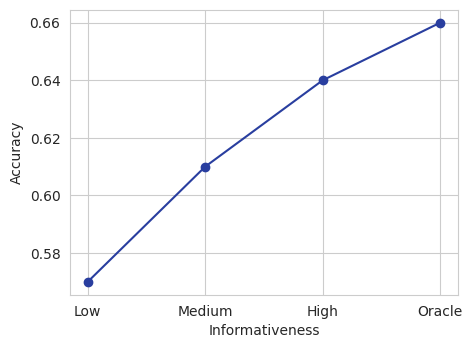

In [251]:
fig = plt.figure(figsize=(5, 3.7))
ax = fig.add_subplot(111)

values = [0.57, 0.61, 0.64, 0.66]

ax.plot(np.arange(len(values)), values, marker="o", color=GREG_PALLETTE[2])

ax.set_xticks(np.arange(len(values)), ["Low", "Medium", "High", "Oracle"], rotation=0)

ax.set_xlabel("Informativeness")
# ax.set_xlim([0.3, 5.5])
ax.set_ylabel("Accuracy")
plt.savefig("figures/informativeness.pdf")
plt.show()

## Test